In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import gaussian_filter

In [2]:
deg2rad = np.pi / 180
np.random.seed(42)

# Signal
n_sig = 100
src_ra = 150
src_dec = 30
sig_ra = np.random.normal(loc=src_ra, scale=2, size=n_sig)
sig_dec = np.random.normal(loc=src_dec, scale=2, size=n_sig)

# Background
n_bkg = 2000
bkg_ra = np.random.uniform(0, 360, n_bkg)
u = np.random.uniform(0, 1, n_bkg)
bkg_dec = np.degrees(np.arcsin(2 * u - 1))  # isotropic in sin(Dec)

ra_all = np.concatenate([bkg_ra, sig_ra])
dec_all = np.concatenate([bkg_dec, sig_dec])
labels_true = np.concatenate([np.zeros(n_bkg), np.ones(n_sig)])

energies = np.concatenate([
    np.random.lognormal(mean=1.5, sigma=0.4, size=n_bkg),
    np.random.lognormal(mean=2.5, sigma=0.3, size=n_sig)
])

df = pd.DataFrame({'RA': ra_all, 'Dec': dec_all, 'Label': labels_true, 'Energy': energies})

In [3]:
df = pd.DataFrame({'RA': ra_all, 'Dec': dec_all, 'Label': labels_true})

ra_rad = df['RA'].values * deg2rad
dec_rad = df['Dec'].values * deg2rad

x = np.cos(dec_rad) * np.cos(ra_rad)
y = np.cos(dec_rad) * np.sin(ra_rad)
z = np.sin(dec_rad)

xyz = np.vstack((x, y, z)).T

Text(0.5, 1.0, 'Ground Truth: Signal (red) vs Background (blue)')

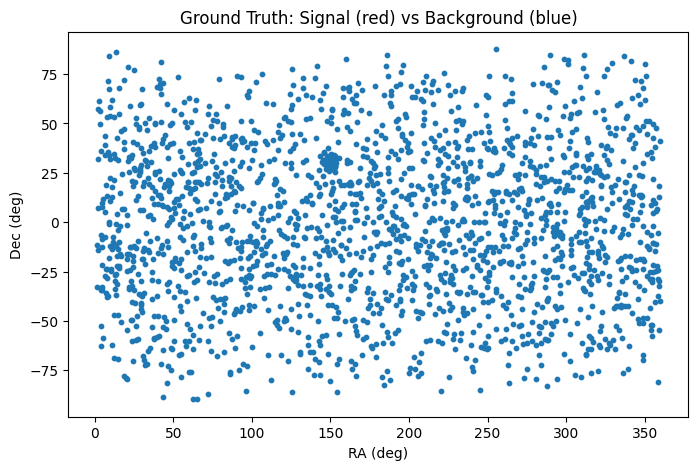

In [4]:
plt.figure(figsize=(8, 5))
plt.scatter(df['RA'], df['Dec'], s=10)#, c=df['Label'], cmap='coolwarm')
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Ground Truth: Signal (red) vs Background (blue)")

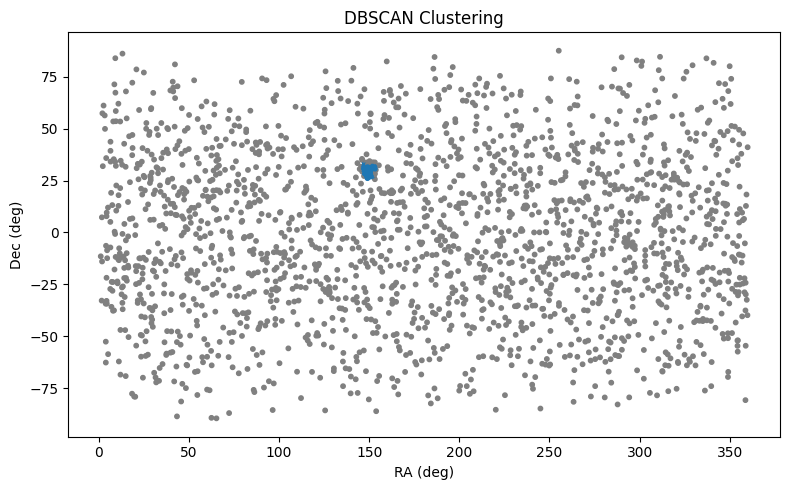

Detected signal events: 83 / 100


In [5]:
eps_rad = 1 * deg2rad
db = DBSCAN(eps=eps_rad, min_samples=6, metric='euclidean')
clusters = db.fit_predict(xyz)
df['Cluster'] = clusters

plt.figure(figsize=(8, 5))
cluster_colors = ['gray' if c == -1 else f'C{c%10}' for c in df['Cluster']]
plt.scatter(df['RA'], df['Dec'], c=cluster_colors, s=10)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

signal_detected = df[(df['Label'] == 1) & (df['Cluster'] != -1)]
print(f"Detected signal events: {len(signal_detected)} / {n_sig}")


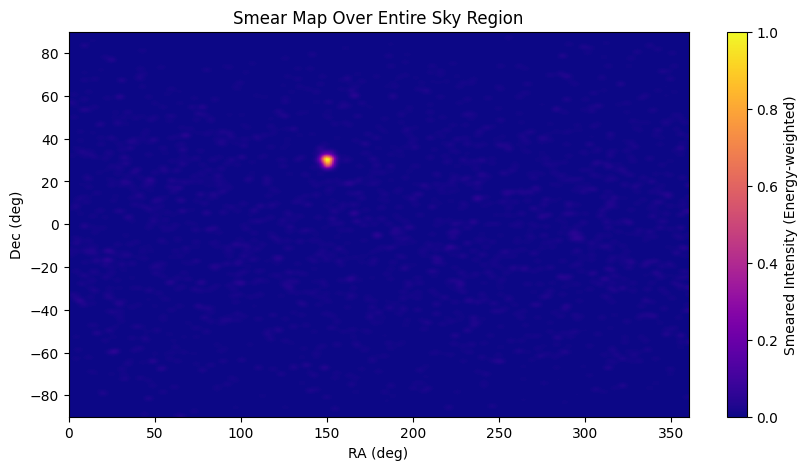

In [19]:
bins = 300
ra_range = (0, 360)
dec_range = (-90, 90)

H, xedges, yedges = np.histogram2d(df['RA'], df['Dec'],
                                   bins=[bins, bins],
                                   range=[ra_range, dec_range],
                                   weights=df['Energy'])

H_smooth = gaussian_filter(H, sigma=1.5)
H_smooth /= H_smooth.max()
vmax = np.max(H_smooth)
plt.figure(figsize=(10, 5))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(H_smooth.T, origin='lower', extent=extent, aspect='auto', cmap='plasma', vmax=vmax)
plt.colorbar(label="Smeared Intensity (Energy-weighted)")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Smear Map Over Entire Sky Region")
plt.show()

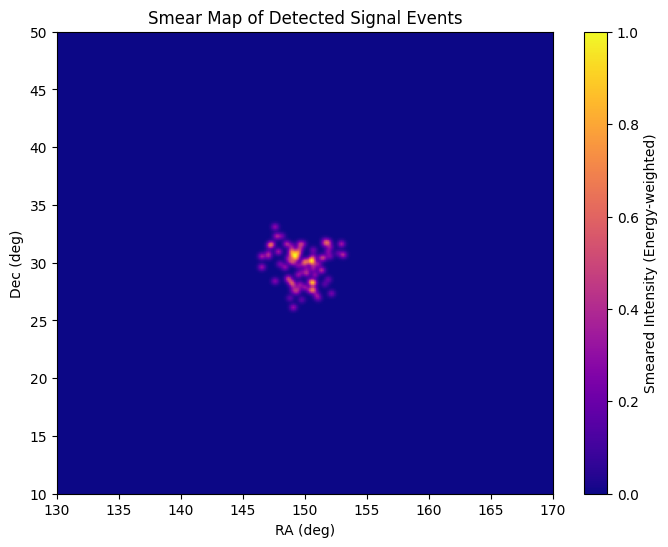

In [20]:
df = pd.DataFrame({'RA': ra_all, 'Dec': dec_all, 'Label': labels_true, 'Energy': energies})

df['Cluster'] = clusters

signal_cluster = df[(df['Label'] == 1) & (df['Cluster'] != -1)]

bins = 300
ra_edges = np.linspace(src_ra - 20, src_ra + 20, bins)
dec_edges = np.linspace(src_dec - 20, src_dec + 20, bins)

H, xedges, yedges = np.histogram2d(signal_cluster['RA'], signal_cluster['Dec'],
                                    bins=[ra_edges, dec_edges],
                                    weights=signal_cluster['Energy'])

H_smooth = gaussian_filter(H, sigma=1.5)
H_smooth /= H_smooth.max()
vmax = np.max(H_smooth)
plt.figure(figsize=(8, 6))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(H_smooth.T, origin='lower', extent=extent, aspect='auto', cmap='plasma', vmax=vmax)
plt.colorbar(label="Smeared Intensity (Energy-weighted)")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Smear Map of Detected Signal Events")
plt.show()